### This version cleaned and without validation (only 1 epoch, so don't use validation) 

In [1]:
# import warnings
# warnings.filterwarnings('ignore') # to suppress some matplotlib deprecation warnings

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import ast
import cv2

import matplotlib.pyplot as plt
import matplotlib.style as style

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import glob
import time
import tqdm

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset

import torchvision
from torchvision import transforms, utils

In [3]:
en_dict = {}
path = '/home/ypw/data/doodle/train_simplified/'

filenames = glob.glob(os.path.join(path, '*.csv'))
filenames = sorted(filenames)

def encode_files():
    """ Encode all label by name of csv_files """
    counter = 0
    for fn in filenames:
        en_dict[fn[:-4].split('/')[-1].replace(' ', '_')] = counter
        counter += 1
        
# collect file names and encode label
encode_files()

dec_dict = {v: k for k, v in en_dict.items()}
def decode_labels(label):
    return dec_dict[label]

def get_label(nfile):
    """ Return encoded label for class by name of csv_files """
    return en_dict[nfile.replace(' ', '_')[:-4]]

## Dataset class and loader
Another example on official  [tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

In [4]:
class DoodlesDataset(Dataset):
    """Doodles csv dataset."""

    def __init__(self, csv_file, root_dir, mode='train', nrows=1000, skiprows=None, size=256, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            mode (string): Train or test mode.
            nrows (int): Number of rows of file to read. Useful for reading pieces of large files.
            skiprows (list-like or integer or callable): 
                    Line numbers to skip (0-indexed) or number of lines to skip (int) at the start of the file.
            size (int): Size of output image.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        file = os.path.join(self.root_dir, csv_file)
        self.size = size
        self.mode = mode
        self.doodle = pd.read_csv(file, usecols=['drawing'], nrows=nrows, skiprows=skiprows)
        self.transform = transform
        if self.mode == 'train':
            self.label = get_label(csv_file)

    @staticmethod
    def _draw(raw_strokes, size=256, lw=6, time_color=True):
        BASE_SIZE = 256
        img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
        for t, stroke in enumerate(raw_strokes):
            for i in range(len(stroke[0]) - 1):
                color = 255 - min(t, 10) * 13 if time_color else 255
                _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                             (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
        if size != BASE_SIZE:
            return cv2.resize(img, (size, size))
        else:
            return img
    
    def __len__(self):
        return len(self.doodle)

    def __getitem__(self, idx):
        raw_strokes = ast.literal_eval(self.doodle.drawing[idx])
        sample = self._draw(raw_strokes, size=self.size, lw=2, time_color=True)
        if self.transform:
            sample = self.transform(sample)
        if self.mode == 'train':
            return (sample[None]/255).astype('float32'), self.label
        else:
            return (sample[None]/255).astype('float32')

### Load data to our DoodlesDataset

In [5]:
SIZE = 224 # for matching to imagenet
# collect all single csvset in one
select_nrows = 40000
doodles = ConcatDataset([DoodlesDataset(fn.split('/')[-1], path, 
                                           nrows=select_nrows, size=SIZE) for fn in filenames])

### Validation set - not used in this version

In [6]:
# select some rows for validation
valid_rows = 100
validationset = ConcatDataset([DoodlesDataset(fn.split('/')[-1], path, nrows=valid_rows, size=SIZE,
                                           skiprows=range(1, select_nrows+1)) for fn in filenames])

In [7]:
# total images in set
print('Train set:', len(doodles))
# print('Validation set:', len(validationset))
# Use the torch dataloader to iterate through the dataset
loader = DataLoader(doodles, batch_size=128, shuffle=True, num_workers=6)
# valid_loader = DataLoader(validationset, batch_size=128, shuffle=False, num_workers=0)

Train set: 13600000


### Get some images from set

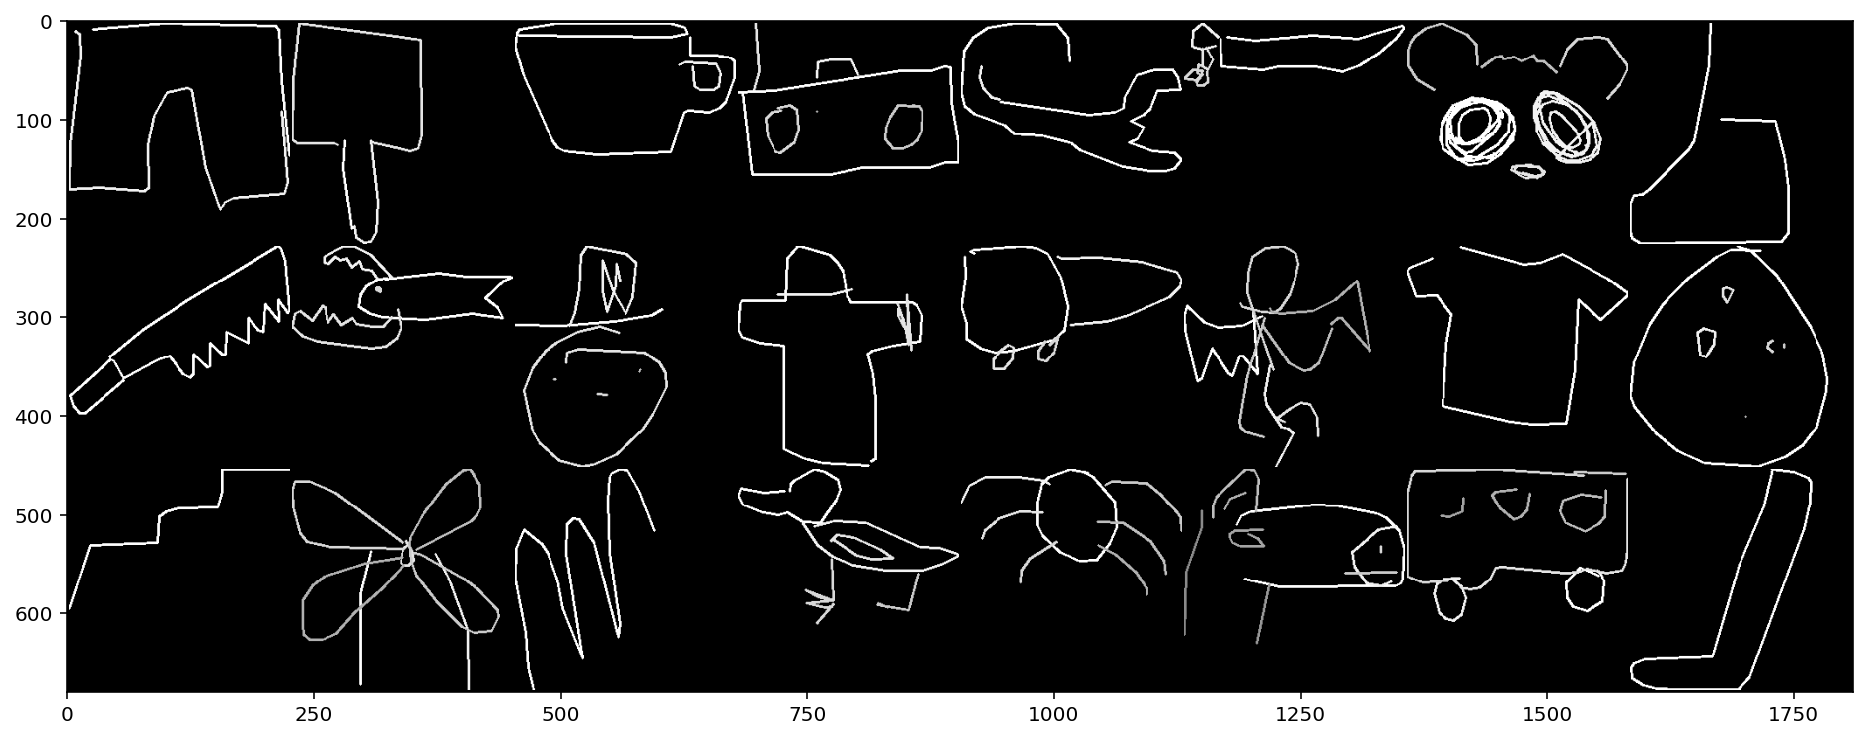

In [8]:
# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some images
dataiter = iter(loader)
images, label = dataiter.next()

# show images
plt.figure(figsize=(16,24))
imshow(torchvision.utils.make_grid(images[:24]))

In [9]:
# validation function 
def validation(lossf, scoref):
    model.eval()
    loss, score = 0, 0
    vlen = len(valid_loader)
    for x, y in valid_loader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        loss += lossf(output, y).item()
        score += scoref(output, y)[0].item()
    model.train()
    return loss/vlen, score/vlen

### Define metric finction

In [10]:
def accuracy(output, target, topk=(3,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [11]:
def mapk(output, target, k=3):
    """
    Computes the mean average precision at k.
    
    Parameters
    ----------
    output (torch.Tensor): A Tensor of predicted elements.
                           Shape: (N,C)  where C = number of classes, N = batch size
    target (torch.int): A Tensor of elements that are to be predicted. 
                        Shape: (N) where each value is  0≤targets[i]≤C−1
    k (int, optional): The maximum number of predicted elements
    
    Returns
    -------
    score (torch.float):  The mean average precision at k over the output
    """
    with torch.no_grad():
        batch_size = target.size(0)

        _, pred = output.topk(k, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        for i in range(k):
            correct[i] = correct[i]*(k-i)
            
        score = correct[:k].view(-1).float().sum(0, keepdim=True)
        score.mul_(1.0 / (k * batch_size))
        return score

### Create model. Loading pretrained version.

In [12]:
model_name = 'resnet34'
model = torchvision.models.resnet34(pretrained=True)

Change number of inputs channels and number of classes. Details about model and code [here](https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py)

In [13]:
# Its first and last layers in model
def squeeze_weights(m):
    m.weight.data = m.weight.data.sum(dim=1)[:,None]
    m.in_channels = 1

model.conv1.apply(squeeze_weights);

num_classes = 340
model.fc = nn.Linear(in_features=512, out_features=num_classes, bias=True)

Test model using random number. Just checking for service.

In [14]:
%%time
# test with random data
model(torch.randn(12,1,224,224)).size()

CPU times: user 3.36 s, sys: 352 ms, total: 3.71 s
Wall time: 1.47 s


torch.Size([12, 340])

In [15]:
model = model.cuda()

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, amsgrad=True)

In [17]:
# PyTorch scheduler:
# https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5000,12000,18000], gamma=0.5)

Training loop with printing information every 1000 iteration

In [18]:
%%time
epochs = 1
lsize = len(loader)
itr = 1
p_itr = 1000 # print every N iteration
model.train()
tloss, score = 0, 0
for epoch in range(epochs):
    with tqdm.tqdm(loader, total=len(loader)) as pbar:
        for x, y in pbar:
            x, y = x.cuda(), y.cuda()
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            tloss += loss.item()
            score += mapk(output, y)[0].item()
            scheduler.step()
            if itr % p_itr==0:
                print('Iteration {} -> Train Loss: {:.4f}, MAP@3: {:.3f}'.format(itr, tloss/p_itr, score/p_itr))
                tloss, score = 0, 0
            itr +=1

  1%|          | 1000/106250 [06:24<11:16:55,  2.59it/s]

Iteration 1000 -> Train Loss: 2.3079, MAP@3: 0.575


  2%|▏         | 2000/106250 [12:49<11:03:12,  2.62it/s]

Iteration 2000 -> Train Loss: 1.5339, MAP@3: 0.728


  3%|▎         | 3000/106250 [19:14<11:12:42,  2.56it/s]

Iteration 3000 -> Train Loss: 1.3503, MAP@3: 0.764


  4%|▍         | 4000/106250 [25:39<11:08:50,  2.55it/s]

Iteration 4000 -> Train Loss: 1.2535, MAP@3: 0.783


  5%|▍         | 5000/106250 [32:03<10:42:06,  2.63it/s]

Iteration 5000 -> Train Loss: 1.1821, MAP@3: 0.797


  6%|▌         | 6000/106250 [38:29<10:57:39,  2.54it/s]

Iteration 6000 -> Train Loss: 1.0604, MAP@3: 0.820


  7%|▋         | 7000/106250 [44:54<10:24:49,  2.65it/s]

Iteration 7000 -> Train Loss: 1.0321, MAP@3: 0.827


  8%|▊         | 8000/106250 [51:19<10:43:15,  2.55it/s]

Iteration 8000 -> Train Loss: 1.0167, MAP@3: 0.828


  8%|▊         | 9000/106250 [57:45<10:29:43,  2.57it/s]

Iteration 9000 -> Train Loss: 1.0021, MAP@3: 0.832


  9%|▉         | 10000/106250 [1:04:10<10:30:26,  2.54it/s]

Iteration 10000 -> Train Loss: 0.9836, MAP@3: 0.835


 10%|█         | 11000/106250 [1:10:36<10:26:01,  2.54it/s]

Iteration 11000 -> Train Loss: 0.9765, MAP@3: 0.837


 11%|█▏        | 12000/106250 [1:17:02<10:05:20,  2.59it/s]

Iteration 12000 -> Train Loss: 0.9580, MAP@3: 0.840


 12%|█▏        | 13000/106250 [1:23:28<9:55:47,  2.61it/s] 

Iteration 13000 -> Train Loss: 0.9110, MAP@3: 0.849


 13%|█▎        | 14000/106250 [1:29:55<9:56:31,  2.58it/s] 

Iteration 14000 -> Train Loss: 0.9084, MAP@3: 0.849


 14%|█▍        | 15000/106250 [1:36:21<9:54:57,  2.56it/s] 

Iteration 15000 -> Train Loss: 0.9013, MAP@3: 0.850


 15%|█▌        | 16000/106250 [1:42:47<9:44:45,  2.57it/s] 

Iteration 16000 -> Train Loss: 0.8857, MAP@3: 0.853


 16%|█▌        | 17000/106250 [1:49:13<9:43:45,  2.55it/s]

Iteration 17000 -> Train Loss: 0.8885, MAP@3: 0.853


 17%|█▋        | 18000/106250 [1:55:39<9:36:35,  2.55it/s]

Iteration 18000 -> Train Loss: 0.8890, MAP@3: 0.852


 18%|█▊        | 19000/106250 [2:02:05<9:14:00,  2.62it/s]

Iteration 19000 -> Train Loss: 0.8649, MAP@3: 0.857


 19%|█▉        | 20000/106250 [2:08:31<9:08:51,  2.62it/s]

Iteration 20000 -> Train Loss: 0.8549, MAP@3: 0.859


 20%|█▉        | 21000/106250 [2:14:57<8:58:38,  2.64it/s]

Iteration 21000 -> Train Loss: 0.8473, MAP@3: 0.861


 21%|██        | 22000/106250 [2:21:23<8:58:57,  2.61it/s]

Iteration 22000 -> Train Loss: 0.8447, MAP@3: 0.861


 22%|██▏       | 23000/106250 [2:27:49<9:01:21,  2.56it/s]

Iteration 23000 -> Train Loss: 0.8452, MAP@3: 0.861


 23%|██▎       | 24000/106250 [2:34:15<8:52:20,  2.58it/s]

Iteration 24000 -> Train Loss: 0.8367, MAP@3: 0.862


 24%|██▎       | 25000/106250 [2:40:41<8:37:13,  2.62it/s]

Iteration 25000 -> Train Loss: 0.8358, MAP@3: 0.862


 24%|██▍       | 26000/106250 [2:47:07<8:40:00,  2.57it/s]

Iteration 26000 -> Train Loss: 0.8366, MAP@3: 0.863


 25%|██▌       | 27000/106250 [2:53:34<8:29:38,  2.59it/s]

Iteration 27000 -> Train Loss: 0.8364, MAP@3: 0.862


 26%|██▋       | 28000/106250 [3:00:00<8:33:57,  2.54it/s]

Iteration 28000 -> Train Loss: 0.8330, MAP@3: 0.863


 27%|██▋       | 29000/106250 [3:06:26<8:11:25,  2.62it/s]

Iteration 29000 -> Train Loss: 0.8309, MAP@3: 0.863


 28%|██▊       | 30000/106250 [3:12:52<8:21:39,  2.53it/s]

Iteration 30000 -> Train Loss: 0.8292, MAP@3: 0.864


 29%|██▉       | 31000/106250 [3:19:18<8:08:48,  2.57it/s]

Iteration 31000 -> Train Loss: 0.8292, MAP@3: 0.864


 30%|███       | 32000/106250 [3:25:45<7:52:09,  2.62it/s]

Iteration 32000 -> Train Loss: 0.8245, MAP@3: 0.863


 31%|███       | 33000/106250 [3:32:11<7:55:42,  2.57it/s]

Iteration 33000 -> Train Loss: 0.8122, MAP@3: 0.866


 32%|███▏      | 34000/106250 [3:38:36<7:41:16,  2.61it/s]

Iteration 34000 -> Train Loss: 0.8135, MAP@3: 0.866


 33%|███▎      | 35000/106250 [3:45:02<7:46:16,  2.55it/s]

Iteration 35000 -> Train Loss: 0.8124, MAP@3: 0.867


 34%|███▍      | 36000/106250 [3:51:28<7:42:46,  2.53it/s]

Iteration 36000 -> Train Loss: 0.8187, MAP@3: 0.865


 35%|███▍      | 37000/106250 [3:57:54<7:22:45,  2.61it/s]

Iteration 37000 -> Train Loss: 0.8225, MAP@3: 0.865


 36%|███▌      | 38000/106250 [4:04:19<7:13:01,  2.63it/s]

Iteration 38000 -> Train Loss: 0.8168, MAP@3: 0.866


 37%|███▋      | 39000/106250 [4:10:45<7:05:55,  2.63it/s]

Iteration 39000 -> Train Loss: 0.8155, MAP@3: 0.866


 38%|███▊      | 40000/106250 [4:17:11<7:03:42,  2.61it/s]

Iteration 40000 -> Train Loss: 0.8091, MAP@3: 0.867


 39%|███▊      | 41000/106250 [4:23:38<7:04:08,  2.56it/s]

Iteration 41000 -> Train Loss: 0.8086, MAP@3: 0.867


 40%|███▉      | 42000/106250 [4:30:04<6:49:16,  2.62it/s]

Iteration 42000 -> Train Loss: 0.8101, MAP@3: 0.867


 40%|████      | 43000/106250 [4:36:30<6:42:31,  2.62it/s]

Iteration 43000 -> Train Loss: 0.8071, MAP@3: 0.867


 41%|████▏     | 44000/106250 [4:42:56<6:46:58,  2.55it/s]

Iteration 44000 -> Train Loss: 0.8123, MAP@3: 0.867


 42%|████▏     | 45000/106250 [4:49:22<6:29:59,  2.62it/s]

Iteration 45000 -> Train Loss: 0.8123, MAP@3: 0.866


 43%|████▎     | 46000/106250 [4:55:48<6:26:57,  2.59it/s]

Iteration 46000 -> Train Loss: 0.8013, MAP@3: 0.868


 44%|████▍     | 47000/106250 [5:02:14<6:23:09,  2.58it/s]

Iteration 47000 -> Train Loss: 0.8003, MAP@3: 0.869


 45%|████▌     | 48000/106250 [5:08:40<6:17:03,  2.57it/s]

Iteration 48000 -> Train Loss: 0.7973, MAP@3: 0.869


 46%|████▌     | 49000/106250 [5:15:06<6:11:06,  2.57it/s]

Iteration 49000 -> Train Loss: 0.8078, MAP@3: 0.867


 47%|████▋     | 50000/106250 [5:21:32<6:09:29,  2.54it/s]

Iteration 50000 -> Train Loss: 0.7885, MAP@3: 0.870


 48%|████▊     | 51000/106250 [5:27:58<5:52:57,  2.61it/s]

Iteration 51000 -> Train Loss: 0.8039, MAP@3: 0.868


 49%|████▉     | 52000/106250 [5:34:24<5:45:26,  2.62it/s]

Iteration 52000 -> Train Loss: 0.7980, MAP@3: 0.869


 50%|████▉     | 53000/106250 [5:40:50<5:41:35,  2.60it/s]

Iteration 53000 -> Train Loss: 0.7867, MAP@3: 0.871


 51%|█████     | 54000/106250 [5:47:16<5:32:02,  2.62it/s]

Iteration 54000 -> Train Loss: 0.8006, MAP@3: 0.868


 52%|█████▏    | 55000/106250 [5:53:43<5:32:15,  2.57it/s]

Iteration 55000 -> Train Loss: 0.7954, MAP@3: 0.869


 53%|█████▎    | 56000/106250 [6:00:09<5:25:43,  2.57it/s]

Iteration 56000 -> Train Loss: 0.7988, MAP@3: 0.869


 54%|█████▎    | 57000/106250 [6:06:35<5:20:06,  2.56it/s]

Iteration 57000 -> Train Loss: 0.7900, MAP@3: 0.871


 55%|█████▍    | 58000/106250 [6:13:02<5:07:21,  2.62it/s]

Iteration 58000 -> Train Loss: 0.7954, MAP@3: 0.870


 56%|█████▌    | 59000/106250 [6:19:28<5:09:50,  2.54it/s]

Iteration 59000 -> Train Loss: 0.7894, MAP@3: 0.870


 56%|█████▋    | 60000/106250 [6:25:54<5:02:23,  2.55it/s]

Iteration 60000 -> Train Loss: 0.7868, MAP@3: 0.871


 57%|█████▋    | 61000/106250 [6:32:21<4:55:25,  2.55it/s]

Iteration 61000 -> Train Loss: 0.7799, MAP@3: 0.872


 58%|█████▊    | 62000/106250 [6:38:47<4:50:33,  2.54it/s]

Iteration 62000 -> Train Loss: 0.7878, MAP@3: 0.871


 59%|█████▉    | 63000/106250 [6:45:13<4:39:57,  2.57it/s]

Iteration 63000 -> Train Loss: 0.7808, MAP@3: 0.872


 60%|██████    | 64000/106250 [6:51:39<4:28:54,  2.62it/s]

Iteration 64000 -> Train Loss: 0.7792, MAP@3: 0.871


 61%|██████    | 65000/106250 [6:58:06<4:22:42,  2.62it/s]

Iteration 65000 -> Train Loss: 0.7834, MAP@3: 0.871


 62%|██████▏   | 66000/106250 [7:04:32<4:19:21,  2.59it/s]

Iteration 66000 -> Train Loss: 0.7758, MAP@3: 0.872


 63%|██████▎   | 67000/106250 [7:10:58<4:10:26,  2.61it/s]

Iteration 67000 -> Train Loss: 0.7777, MAP@3: 0.872


 64%|██████▍   | 68000/106250 [7:17:24<4:07:02,  2.58it/s]

Iteration 68000 -> Train Loss: 0.7786, MAP@3: 0.872


 65%|██████▍   | 69000/106250 [7:23:50<4:03:38,  2.55it/s]

Iteration 69000 -> Train Loss: 0.7798, MAP@3: 0.872


 66%|██████▌   | 70000/106250 [7:30:15<3:53:57,  2.58it/s]

Iteration 70000 -> Train Loss: 0.7821, MAP@3: 0.872


 67%|██████▋   | 71000/106250 [7:36:41<3:46:13,  2.60it/s]

Iteration 71000 -> Train Loss: 0.7784, MAP@3: 0.872


 68%|██████▊   | 72000/106250 [7:43:07<3:42:39,  2.56it/s]

Iteration 72000 -> Train Loss: 0.7787, MAP@3: 0.872


 69%|██████▊   | 73000/106250 [7:49:33<3:34:57,  2.58it/s]

Iteration 73000 -> Train Loss: 0.7740, MAP@3: 0.873


 70%|██████▉   | 74000/106250 [7:55:59<3:26:32,  2.60it/s]

Iteration 74000 -> Train Loss: 0.7694, MAP@3: 0.874


 71%|███████   | 75000/106250 [8:02:25<3:18:38,  2.62it/s]

Iteration 75000 -> Train Loss: 0.7758, MAP@3: 0.873


 72%|███████▏  | 76000/106250 [8:08:52<3:18:01,  2.55it/s]

Iteration 76000 -> Train Loss: 0.7790, MAP@3: 0.872


 72%|███████▏  | 77000/106250 [8:15:18<3:06:15,  2.62it/s]

Iteration 77000 -> Train Loss: 0.7728, MAP@3: 0.873


 73%|███████▎  | 78000/106250 [8:21:45<3:05:04,  2.54it/s]

Iteration 78000 -> Train Loss: 0.7743, MAP@3: 0.873


 74%|███████▍  | 79000/106250 [8:28:11<2:52:36,  2.63it/s]

Iteration 79000 -> Train Loss: 0.7789, MAP@3: 0.872


 75%|███████▌  | 80000/106250 [8:34:37<2:52:12,  2.54it/s]

Iteration 80000 -> Train Loss: 0.7632, MAP@3: 0.874


 76%|███████▌  | 81000/106250 [8:41:04<2:43:17,  2.58it/s]

Iteration 81000 -> Train Loss: 0.7640, MAP@3: 0.875


 77%|███████▋  | 82000/106250 [8:47:30<2:34:59,  2.61it/s]

Iteration 82000 -> Train Loss: 0.7589, MAP@3: 0.875


 78%|███████▊  | 83000/106250 [8:53:57<2:31:06,  2.56it/s]

Iteration 83000 -> Train Loss: 0.7691, MAP@3: 0.874


 79%|███████▉  | 84000/106250 [9:00:23<2:23:19,  2.59it/s]

Iteration 84000 -> Train Loss: 0.7626, MAP@3: 0.875


 80%|████████  | 85000/106250 [9:06:50<2:15:58,  2.60it/s]

Iteration 85000 -> Train Loss: 0.7699, MAP@3: 0.875


 81%|████████  | 86000/106250 [9:13:16<2:10:32,  2.59it/s]

Iteration 86000 -> Train Loss: 0.7719, MAP@3: 0.873


 82%|████████▏ | 87000/106250 [9:19:43<2:02:47,  2.61it/s]

Iteration 87000 -> Train Loss: 0.7640, MAP@3: 0.875


 83%|████████▎ | 88000/106250 [9:26:10<1:55:53,  2.62it/s]

Iteration 88000 -> Train Loss: 0.7652, MAP@3: 0.875


 84%|████████▍ | 89000/106250 [9:32:36<1:49:59,  2.61it/s]

Iteration 89000 -> Train Loss: 0.7654, MAP@3: 0.875


 85%|████████▍ | 90000/106250 [9:39:03<1:42:56,  2.63it/s]

Iteration 90000 -> Train Loss: 0.7663, MAP@3: 0.875


 86%|████████▌ | 91000/106250 [9:45:30<1:39:58,  2.54it/s]

Iteration 91000 -> Train Loss: 0.7571, MAP@3: 0.876


 87%|████████▋ | 92000/106250 [9:51:56<1:30:24,  2.63it/s]

Iteration 92000 -> Train Loss: 0.7621, MAP@3: 0.876


 88%|████████▊ | 93000/106250 [9:58:23<1:26:32,  2.55it/s]

Iteration 93000 -> Train Loss: 0.7603, MAP@3: 0.876


 88%|████████▊ | 94000/106250 [10:04:49<1:19:09,  2.58it/s]

Iteration 94000 -> Train Loss: 0.7607, MAP@3: 0.875


 89%|████████▉ | 95000/106250 [10:11:16<1:11:17,  2.63it/s]

Iteration 95000 -> Train Loss: 0.7577, MAP@3: 0.875


 90%|█████████ | 96000/106250 [10:17:43<1:05:28,  2.61it/s]

Iteration 96000 -> Train Loss: 0.7636, MAP@3: 0.875


 91%|█████████▏| 97000/106250 [10:24:09<1:00:13,  2.56it/s]

Iteration 97000 -> Train Loss: 0.7617, MAP@3: 0.875


 92%|█████████▏| 98000/106250 [10:30:35<52:53,  2.60it/s]  

Iteration 98000 -> Train Loss: 0.7497, MAP@3: 0.878


 93%|█████████▎| 99000/106250 [10:37:00<45:52,  2.63it/s]

Iteration 99000 -> Train Loss: 0.7597, MAP@3: 0.876


 94%|█████████▍| 100000/106250 [10:43:25<39:34,  2.63it/s]

Iteration 100000 -> Train Loss: 0.7553, MAP@3: 0.877


 95%|█████████▌| 101000/106250 [10:49:50<34:23,  2.54it/s]

Iteration 101000 -> Train Loss: 0.7571, MAP@3: 0.875


 96%|█████████▌| 102000/106250 [10:56:15<27:25,  2.58it/s]

Iteration 102000 -> Train Loss: 0.7587, MAP@3: 0.875


 97%|█████████▋| 103000/106250 [11:02:40<20:37,  2.63it/s]

Iteration 103000 -> Train Loss: 0.7535, MAP@3: 0.877


 98%|█████████▊| 104000/106250 [11:09:06<14:36,  2.57it/s]

Iteration 104000 -> Train Loss: 0.7474, MAP@3: 0.878


 99%|█████████▉| 105000/106250 [11:15:31<07:57,  2.62it/s]

Iteration 105000 -> Train Loss: 0.7431, MAP@3: 0.878


100%|█████████▉| 106000/106250 [11:21:56<01:38,  2.53it/s]

Iteration 106000 -> Train Loss: 0.7560, MAP@3: 0.877


100%|██████████| 106250/106250 [11:23:33<00:00,  2.62it/s]

CPU times: user 9h 57min 21s, sys: 1h 26min 45s, total: 11h 24min 7s
Wall time: 11h 23min 33s


### Save model state

In [19]:
os.makedirs('checkpoints', exist_ok=True)
filename_pth = f'checkpoints/{model_name}.pth'
torch.save(model.state_dict(), filename_pth)

### And finally predict for test set 

In [20]:
testset = DoodlesDataset('test_simplified.csv', '/home/ypw/data/doodle/', 
                         mode='test', nrows=None, size=SIZE)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=4)

In [21]:
model.eval()
labels = np.empty((0,3))
with tqdm.tqdm(testloader) as pbar:
    for x in pbar:
        x = x.cuda()
        output = model(x)
        _, pred = output.topk(3, 1, True, True)
        labels = np.concatenate([labels, pred], axis = 0)

100%|██████████| 877/877 [01:46<00:00,  8.21it/s]


In [24]:
%%time
submission = pd.read_csv('/home/ypw/data/doodle/test_simplified.csv', index_col='key_id')
submission.drop(['countrycode', 'drawing'], axis=1, inplace=True)
submission['word'] = ''
for i, label in enumerate(labels):
    submission.word.iloc[i] = " ".join([decode_labels(l) for l in label])

CPU times: user 2min 55s, sys: 1.12 s, total: 2min 56s
Wall time: 2min 55s


In [25]:
submission.to_csv(f'preds_{model_name}.csv')